In [45]:
#Importamos la librería pandas que necesitamos para la lectura, conversión y limpieza de los datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import re 

#Importamos librerías necesarias para la visualización
# -----------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

from scipy.stats import shapiro, kstest
from itertools import combinations  # para las medidas de correlación
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames
# pd.set_option('display.max_rows', None) # para poder visualizar todas las filas de los DataFrames



In [46]:
from src import Functions

In [47]:
#pasar a df

df_flight = pd.read_csv('Customer Flight Activity.csv')
df_loyalty = pd.read_csv('Customer Loyalty History.csv')

## Fase 1: Exploración y Limpieza

### 1. Exploración inicial

In [48]:
#pre visualizacion

df_flight.head(2)

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed
0,100018,2017,1,3,0,3,1521,152.0,0,0
1,100102,2017,1,10,4,14,2030,203.0,0,0


In [49]:
#pre visualizacion

df_loyalty.head(2)

,Loyalty Number,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,480934,Canada,Ontario,Toronto,M2Z 4K1,Female,Bachelor,83236.0,Married,Star,3839.14,Standard,2016,2,NaN,NaN
1,549612,Canada,Alberta,Edmonton,T3G 6Y6,Male,College,NaN,Divorced,Star,3839.61,Standard,2016,3,NaN,NaN


In [50]:
def exploracion_datos(df):
    print('_____________ INFORMACIÓN GENERAL DEL DATAFRAME ____________\n')
    print(df.info())

    print('___________________ FORMA DEL DATAFRAME ____________________\n')
    
    print(f"El número de filas que tenemos es de {df.shape[0]}.\nEl número de columnas es de {df.shape[1]}\n")
    

    print('_______________ NULOS, ÚNICOS Y DUPLICADOS _________________\n')
    
    print('La cantidad de valores NULOS por columna es de:\n')
    print(df.isnull().sum())
    print('____________________________________________________________\n')

    print('La cantidad de valores ÚNICOS por columna es de:\n')
        
    for columna in df.columns:
        cantidad_valores_unicos = len(df[columna].unique())
    
        print(f'La columna {columna}: {cantidad_valores_unicos}')

    """ Otra forma más rápida de obtener la lista de valores únicos por columna es usando df.nunique()"""

    print('____________________________________________________________\n')

    print('La cantidad de valores DUPLICADOS por columna es de:\n')

    """En análisis posteriores hemos detectado que hay columnas con valores duplicados que nos interesa filtrar, 
    así que vamos a realizar otro bucle for para iterar por todas las columnas del DF y obtener los duplicados de cada una de ellas."""

    for columna in df.columns:
        cantidad_duplicados = df[columna].duplicated().sum()
    
        print(f'La columna {columna}: {cantidad_duplicados}')

    try:
        print('____________________ RESUMEN ESTADÍSTICO ____________________')
        print('____________________ Variables Numéricas __________________\n')
        print(df.describe().T)
    
        print('___________________ Variables Categóricas _________________\n')
        print(df.describe(include='object').T)
    except ValueError as e:
        if 'No objects to concatenate' in str(e):
            print('No hay variables categóricas en el DataFrame.')
        else:
            raise e


In [51]:
exploracion_datos(df_flight)

_____________ INFORMACIÓN GENERAL DEL DATAFRAME ____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Loyalty Number               405624 non-null  int64  
 1   Year                         405624 non-null  int64  
 2   Month                        405624 non-null  int64  
 3   Flights Booked               405624 non-null  int64  
 4   Flights with Companions      405624 non-null  int64  
 5   Total Flights                405624 non-null  int64  
 6   Distance                     405624 non-null  int64  
 7   Points Accumulated           405624 non-null  float64
 8   Points Redeemed              405624 non-null  int64  
 9   Dollar Cost Points Redeemed  405624 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 30.9 MB
None
___________________ FORMA DEL DATAFRAME ____________________

E

In [52]:
exploracion_datos(df_loyalty)

_____________ INFORMACIÓN GENERAL DEL DATAFRAME ____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16737 entries, 0 to 16736
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Loyalty Number      16737 non-null  int64  
 1   Country             16737 non-null  object 
 2   Province            16737 non-null  object 
 3   City                16737 non-null  object 
 4   Postal Code         16737 non-null  object 
 5   Gender              16737 non-null  object 
 6   Education           16737 non-null  object 
 7   Salary              12499 non-null  float64
 8   Marital Status      16737 non-null  object 
 9   Loyalty Card        16737 non-null  object 
 10  CLV                 16737 non-null  float64
 11  Enrollment Type     16737 non-null  object 
 12  Enrollment Year     16737 non-null  int64  
 13  Enrollment Month    16737 non-null  int64  
 14  Cancellation Year   2067 non-null   floa

In [53]:
merge = df_flight.merge(df_loyalty, left_on= 'Loyalty Number', right_on = 'Loyalty Number' )
merge

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
1,100018,2017,2,2,2,4,1320,132.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
2,100018,2018,10,6,4,10,3110,311.0,385,31,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
3,100018,2017,4,4,0,4,924,92.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
4,100018,2017,5,0,0,0,0,0.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405619,999891,2018,8,0,0,0,0,0.0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0
405620,999891,2018,9,0,0,0,0,0.0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0
405621,999891,2018,10,0,0,0,0,0.0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0
405622,999891,2018,11,0,0,0,0,0.0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0


In [54]:
merge.drop_duplicates()

,Loyalty Number,Year,Month,Flights Booked,Flights with Companions,Total Flights,Distance,Points Accumulated,Points Redeemed,Dollar Cost Points Redeemed,Country,Province,City,Postal Code,Gender,Education,Salary,Marital Status,Loyalty Card,CLV,Enrollment Type,Enrollment Year,Enrollment Month,Cancellation Year,Cancellation Month
0,100018,2017,1,3,0,3,1521,152.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
1,100018,2017,2,2,2,4,1320,132.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
2,100018,2018,10,6,4,10,3110,311.0,385,31,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
3,100018,2017,4,4,0,4,924,92.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
4,100018,2017,5,0,0,0,0,0.0,0,0,Canada,Alberta,Edmonton,T9G 1W3,Female,Bachelor,92552.0,Married,Aurora,7919.20,Standard,2016,8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405619,999891,2018,8,0,0,0,0,0.0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0
405620,999891,2018,9,0,0,0,0,0.0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0
405621,999891,2018,10,0,0,0,0,0.0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0
405622,999891,2018,11,0,0,0,0,0.0,0,0,Canada,Nova Scotia,Halifax,B3J 9S2,Female,Bachelor,75616.0,Married,Nova,3745.37,Standard,2016,5,2017.0,1.0


### 2. Limpieza de datos

In [55]:
#eliminar columnas

def eliminar_columnas(df, columnas):
    df.drop(columns= columnas, inplace= True)
    return df

In [56]:
#Eliminar columnas que no sirven para el análisis

columnas_eliminar= ['Flights with Companions', 'Points Redeemed', 'Dollar Cost Points Redeemed','Postal Code', 'CLV', 'Enrollment Type', 'Enrollment Month', 'Cancellation Year', 'Cancellation Month' ]

eliminar_columnas(merge, columnas_eliminar )


,Loyalty Number,Year,Month,Flights Booked,Total Flights,Distance,Points Accumulated,Country,Province,City,Gender,Education,Salary,Marital Status,Loyalty Card,Enrollment Year
0,100018,2017,1,3,3,1521,152.0,Canada,Alberta,Edmonton,Female,Bachelor,92552.0,Married,Aurora,2016
1,100018,2017,2,2,4,1320,132.0,Canada,Alberta,Edmonton,Female,Bachelor,92552.0,Married,Aurora,2016
2,100018,2018,10,6,10,3110,311.0,Canada,Alberta,Edmonton,Female,Bachelor,92552.0,Married,Aurora,2016
3,100018,2017,4,4,4,924,92.0,Canada,Alberta,Edmonton,Female,Bachelor,92552.0,Married,Aurora,2016
4,100018,2017,5,0,0,0,0.0,Canada,Alberta,Edmonton,Female,Bachelor,92552.0,Married,Aurora,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405619,999891,2018,8,0,0,0,0.0,Canada,Nova Scotia,Halifax,Female,Bachelor,75616.0,Married,Nova,2016
405620,999891,2018,9,0,0,0,0.0,Canada,Nova Scotia,Halifax,Female,Bachelor,75616.0,Married,Nova,2016
405621,999891,2018,10,0,0,0,0.0,Canada,Nova Scotia,Halifax,Female,Bachelor,75616.0,Married,Nova,2016
405622,999891,2018,11,0,0,0,0.0,Canada,Nova Scotia,Halifax,Female,Bachelor,75616.0,Married,Nova,2016


In [57]:
exploracion_datos(merge)

_____________ INFORMACIÓN GENERAL DEL DATAFRAME ____________

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405624 entries, 0 to 405623
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Loyalty Number      405624 non-null  int64  
 1   Year                405624 non-null  int64  
 2   Month               405624 non-null  int64  
 3   Flights Booked      405624 non-null  int64  
 4   Total Flights       405624 non-null  int64  
 5   Distance            405624 non-null  int64  
 6   Points Accumulated  405624 non-null  float64
 7   Country             405624 non-null  object 
 8   Province            405624 non-null  object 
 9   City                405624 non-null  object 
 10  Gender              405624 non-null  object 
 11  Education           405624 non-null  object 
 12  Salary              302952 non-null  float64
 13  Marital Status      405624 non-null  object 
 14  Loyalty Card        40

Convertir datos de numpy.int64 a int

In [58]:
def convertir_int(df, columnas_convertir):
    df[columnas_convertir] = df[columnas_convertir].astype('int64')
    return(df.dtypes)

In [59]:
columnas = ['Year', 'Flights Booked', 'Month']

convertir_int(merge, columnas)

Loyalty Number          int64
Year                    int64
Month                   int64
Flights Booked          int64
Total Flights           int64
Distance                int64
Points Accumulated    float64
Country                object
Province               object
City                   object
Gender                 object
Education              object
Salary                float64
Marital Status         object
Loyalty Card           object
Enrollment Year         int64
dtype: object

### Recursos para analizar con que conviene imputar

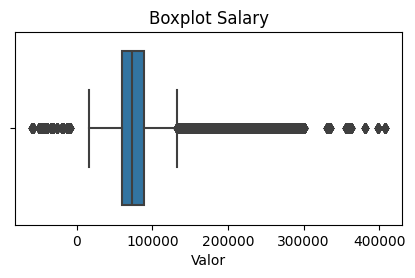

In [60]:
# Boxplot para ver la distribución de datos en la columna Salario para tomar una decisión de
# con qué conviene reemplazar

plt.figure(figsize=(5, 2.5))
sns.boxplot(x=merge['Salary'])
plt.title('Boxplot Salary')
plt.xlabel('Valor')
plt.show()


In [61]:
#media

merge['Salary'].mean()

79268.82595262615

In [62]:
#mediana

merge['Salary'].median()

73479.0

In [63]:
nulos_salario = merge['Salary'].isnull().sum()
nulos_salario

102672

In [64]:
def porcentaje_nulos(nulos, cant_datos):
    promedio = nulos / cant_datos
    return promedio

In [65]:
porcentaje_nulos(nulos_salario, 405624)

0.2531211170936631

In [66]:
#decisión tomada: imputar con la mediana

def imputar_mediana(df, columna):
    #calcular mediana
    mediana = df[columna].median()
    #reemplazar valores 
    df[columna] = df[columna].fillna(mediana)
    #comprobar nulos
    print(f"Después del 'fillna' tenemos {df[columna].isnull().sum()} nulos")

In [67]:
imputar_mediana(merge, 'Salary')

Después del 'fillna' tenemos 0 nulos


In [68]:
#pasar salarios negativos a positivos
#Buscamos los valores negativos de la columna 'DistanceFromHome'
valores_negativos = merge[merge['Salary'] < 0]['Salary']
print(valores_negativos)
print('_________________________________________________')
print(f'Hay {valores_negativos.shape[0]} filas con valores negativos')

6408     -10605.0
6409     -10605.0
6410     -10605.0
6411     -10605.0
6412     -10605.0
           ...   
387691   -46470.0
387692   -46470.0
387693   -46470.0
387694   -46470.0
387695   -46470.0
Name: Salary, Length: 480, dtype: float64
_________________________________________________
Hay 480 filas con valores negativos


In [69]:
#Sustituimos valores negativos por positivos
merge.loc[merge['Salary'] < 0, 'Salary'] = merge['Salary'].abs()

#Comprobamos que ya no hay valores negativos
merge[merge['Salary'] < 0]

,Loyalty Number,Year,Month,Flights Booked,Total Flights,Distance,Points Accumulated,Country,Province,City,Gender,Education,Salary,Marital Status,Loyalty Card,Enrollment Year


## Fase 2: Visualización

¿Cómo se distribuye la cantidad de vuelos reservados por mes durante el año?

In [70]:
merge['Year'].unique()

array([2017, 2018])

 ¿Existe una relación entre la distancia de los vuelos y los puntos acumulados por los clientes?

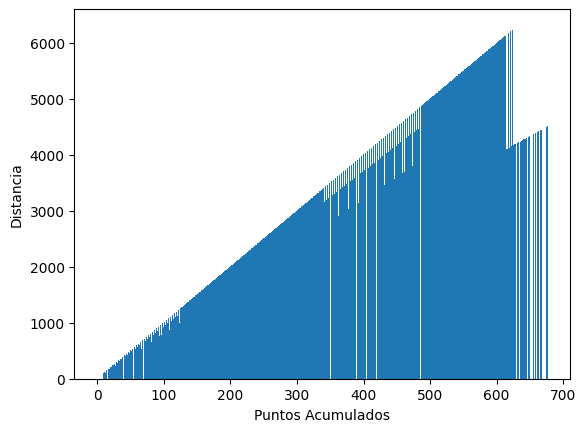

In [71]:
plt.bar(x= merge['Points Accumulated'], height= merge['Distance'])
plt.xlabel("Puntos Acumulados")
plt.ylabel("Distancia");

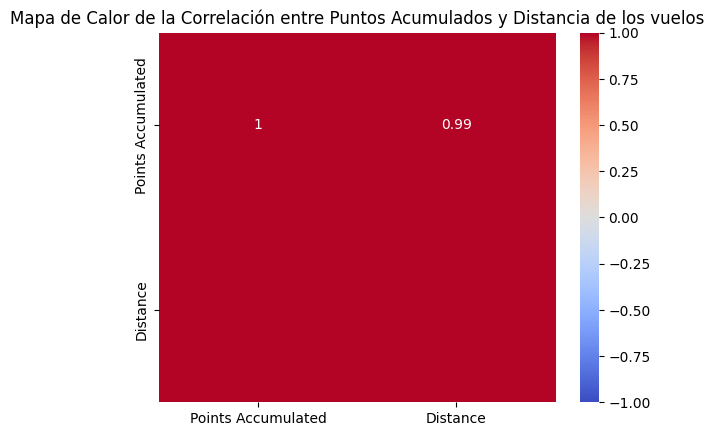

In [72]:
# Seleccionar solo las columnas que queremos correlacionar
df_correlacion = merge[['Points Accumulated', 'Distance' ]]

# Calcular la matriz de correlación
matriz_correlacion = df_correlacion.corr()

# Crear el mapa de calor
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# Configurar el título del mapa de calor
plt.title('Mapa de Calor de la Correlación entre Puntos Acumulados y Distancia de los vuelos')

# Mostrar el mapa de calor
plt.show()

Se puede decir que sí existe una relación entre la distancia de los vuelos y los puntos acumulados por los clientes

¿Cuál es la distribución de los clientes por provincia o estado?

In [73]:
#Agrupar para facilitar la visualizacion

grouped_df = merge.groupby('Province')['Loyalty Number'].count().reset_index()
grouped_df

,Province,Loyalty Number
0,Alberta,23400
1,British Columbia,106848
2,Manitoba,15984
3,New Brunswick,15432
4,Newfoundland,6312
5,Nova Scotia,12576
6,Ontario,130896
7,Prince Edward Island,1584
8,Quebec,79968
9,Saskatchewan,9936


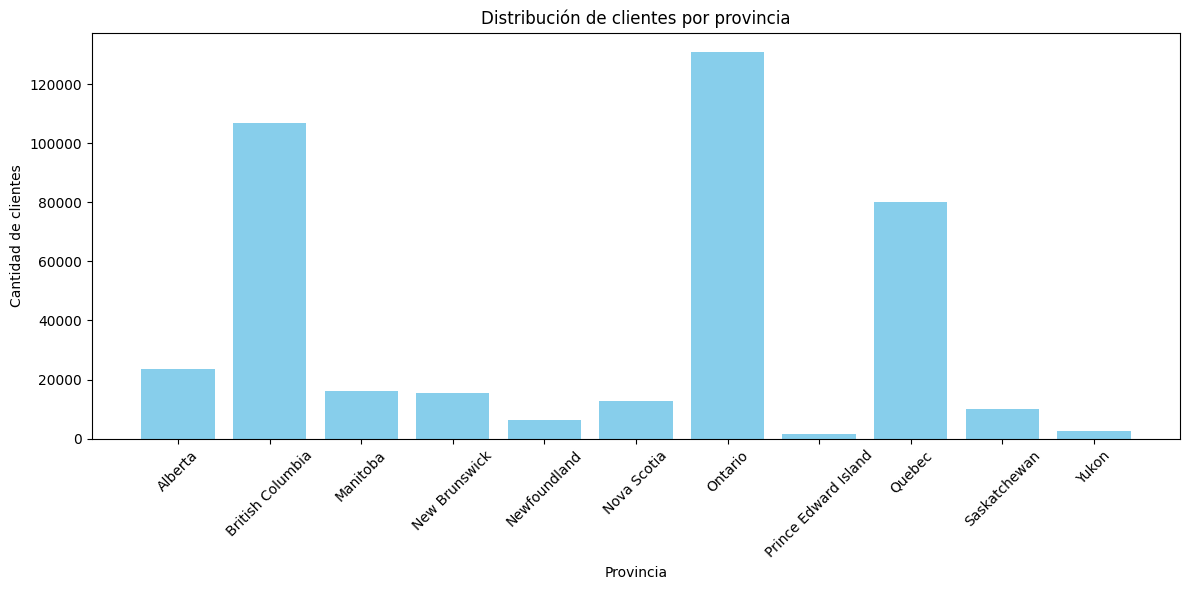

In [74]:
# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(grouped_df['Province'], grouped_df['Loyalty Number'], color='skyblue')

# Añadir títulos y etiquetas
plt.title('Distribución de clientes por provincia')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de clientes')

# Mejorar la legibilidad de las etiquetas del eje x
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


 ¿Cómo se compara el salario promedio entre los diferentes niveles educativos de los clientes?

In [75]:
#Agrupar para facilitar la visualizacion

grouped_df = merge.groupby('Education')['Salary'].mean().reset_index()
grouped_df

,Education,Salary
0,Bachelor,72601.235033
1,College,73479.000000
2,Doctor,178335.439516
3,High School or Below,61112.377525
4,Master,103767.494163


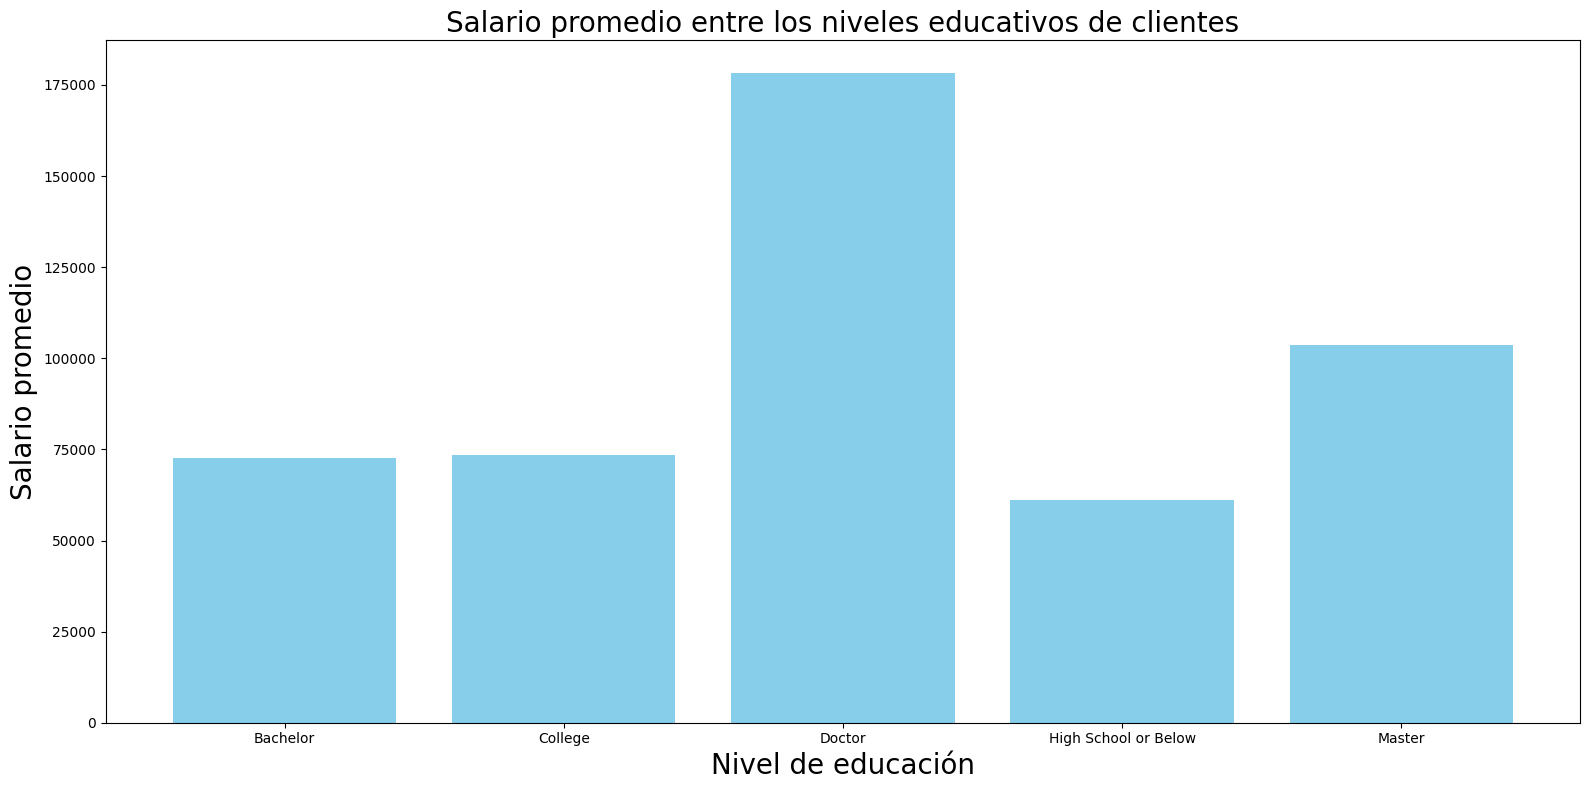

In [76]:
# Crear el gráfico de barras
plt.figure(figsize=(16, 8))
plt.bar(grouped_df['Education'], grouped_df['Salary'], color='skyblue')

# Añadir títulos y etiquetas
plt.title('Salario promedio entre los niveles educativos de clientes', fontsize=20)
plt.xlabel('Nivel de educación', fontsize=20)
plt.ylabel('Salario promedio', fontsize=20)


# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [299]:
merge['Salary'].mean()

77887.4079640258

¿Cuál es la proporción de clientes con diferentes tipos de tarjetas de fidelidad?

In [77]:
#Agrupar para facilitar la visualizacion

grouped_df = merge.groupby('Loyalty Card')['Loyalty Number'].count().reset_index()
grouped_df

,Loyalty Card,Loyalty Number
0,Aurora,83832
1,Nova,137568
2,Star,184224


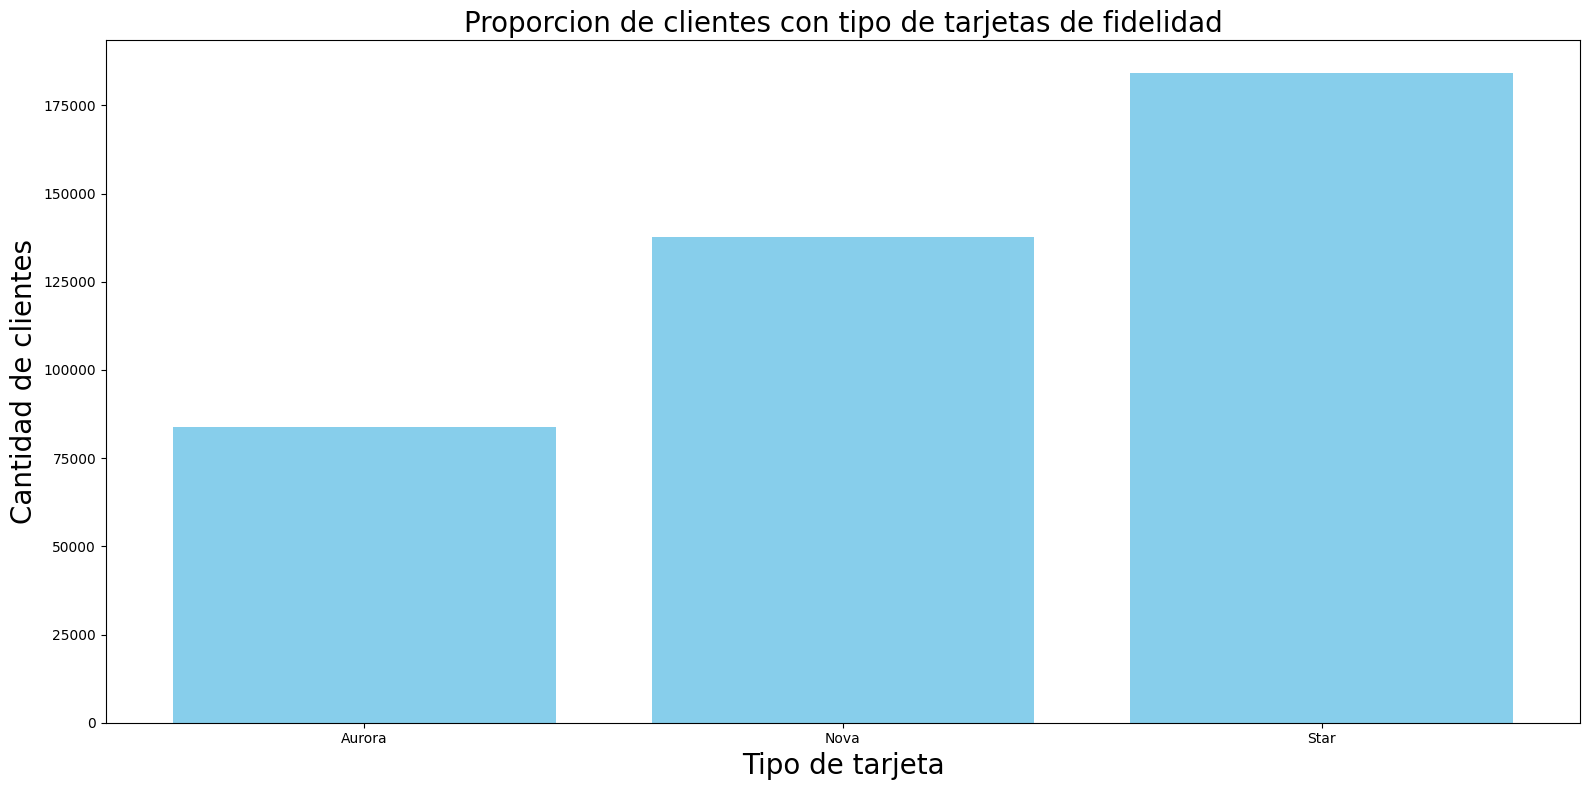

In [78]:
# Crear el gráfico de barras
plt.figure(figsize=(16, 8))
plt.bar(grouped_df['Loyalty Card'], grouped_df['Loyalty Number'], color='skyblue')

# Añadir títulos y etiquetas
plt.title('Proporcion de clientes con tipo de tarjetas de fidelidad', fontsize=20)
plt.xlabel('Tipo de tarjeta', fontsize=20)
plt.ylabel('Cantidad de clientes', fontsize=20)


# Mostrar el gráfico
plt.tight_layout()
plt.show()

¿Cómo se distribuyen los clientes según su estado civil y género?

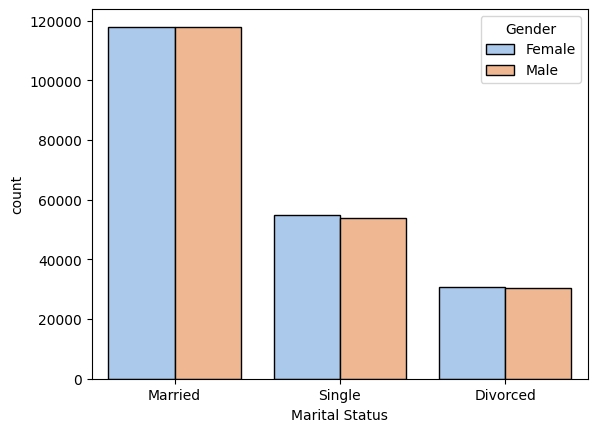

In [91]:
sns.countplot(x = "Marital Status", 
              data = merge,
              hue = 'Gender', 
              palette = "pastel",
              edgecolor = 'black'
              );